In [1]:
#!git clone https://github.com/zigolox/importance-weighted-autoencoders.git
#%cd "importance-weighted-autoencoders/"

In [2]:
#%%capture
#!pip install --upgrade einops optax

In [3]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, apply_updates, chain, clip
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
from loss import iwae_loss
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import gelu, sigmoid
from jax import disable_jit
from jaxopt import FixedPointIteration



# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def normalize_img(image):
    """Normalizes images: `uint8` -> `float32`."""
    x = rearrange(image["image"], "h w c -> c h w")
    return x

# Load the dataset
#train, test = tfds.load("binarized_mnist", split=["train+validation","test"], data_dir="data", shuffle_files=True, as_supervised=False)
train = tfds.load("binarized_mnist", split="train", data_dir="data", shuffle_files=True, as_supervised=False)
train = train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = jnp.array([*train.as_numpy_iterator()],dtype=jnp.float32)

In [5]:
def batch_loss(model, x: Array, T: int, key: PRNGKeyArray) -> Array:
    '''Compute the VAE loss.'''

    def loss(x: Array, key: PRNGKeyArray):

        x_rec, x_rec_prev = model(seed_image, T, key=key)
        
        log = reduce(Bernoulli(logits=x_rec[0]).log_prob(x[0]), 'h w -> ', 'sum')
        # Make it stationary
        #prev_img = reduce(jnp.abs(x_rec[0]-x_rec_prev[0]), 'h w -> ', 'sum')
        #prev_latent = reduce(jnp.abs(x_rec[1:]-x_rec_prev[1:]), 'c h w -> c', 'sum').mean()
        #print(log)
        # Marginalize log likelihood
        return log# - (prev_img + prev_latent)

    keys = split(key, x.shape[0])
    # Mean over the batch
    return -vmap(loss)(x, keys).mean()

class Conv2dZeroInit(eqx.nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = jnp.zeros_like(self.weight)
        self.bias = jnp.zeros_like(self.bias)

def fp_step(z,conv_around,conv_linear):
    p = conv_around(z)
    l = conv_linear(p)
    return z + gelu(l)
        
class ModelStep(eqx.Module):
    conv_around: eqx.nn.Conv2d
    conv_linear: eqx.nn.Conv2d
    max_steps : int
    latent_size : int
    fpi : FixedPointIteration
    
    def __init__(self, latent_size: int, max_steps : int, *, key: PRNGKeyArray) -> None:
        key, key1 = split(key)
        self.conv_around = eqx.nn.Conv2d(latent_size, latent_size, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), key=key)
        self.conv_linear = eqx.nn.Conv2d(latent_size, latent_size, kernel_size=(1, 1), stride=(1, 1), key=key1)
        #self.conv_linear = Conv2dZeroInit(latent_size, latent_size, kernel_size=(1, 1), stride=(1, 1), key=key1)
        self.max_steps = max_steps
        self.latent_size = latent_size
        self.fpi = FixedPointIteration(fixed_point_fun=fp_step,maxiter=self.max_steps,implicit_diff=True)
        
    def __call__(self, x: Array, T: int,*, key: Optional[PRNGKeyArray] = None) -> Array:
        z = repeat(x[0],"h w -> l h w",l=latent_size)
        #z_all = self.fixpoint_solver(z, T)
        z_all = self.fpi.run(z,self.conv_around,self.conv_linear).params
        return z_all[:1,...],z_all[:1,...]
        
    def fixpoint_solver(self, z: Array, T: Array) -> Array:
        # Apply the NCA steps
        true_fun = lambda z: self.step(z)
        false_fun = lambda z: z

        #@checkpoint
        def scan_fn(z: Array, t: int) -> Tuple[Array, Any]:
            z = lax.cond(t, true_fun, false_fun, z)
            return z, z

        z, z_all = lax.scan(scan_fn, z, (jnp.arange(self.max_steps) <= T))

        return z_all
    

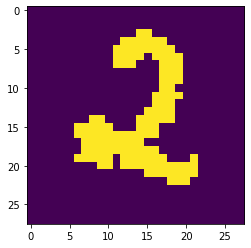

In [6]:
import matplotlib.pyplot as plt
# Choose simple image to predict
train_image = train[11:12]
plt.imshow(train_image[0][0])
plt.show()

In [7]:
epochs = 6
batch_size = 5
latent_size= 5
min_steps = 10
max_steps = 100

# Initialize the model
model = ModelStep(key=MODEL_KEY,latent_size=latent_size,max_steps=max_steps)

seed_image = jnp.zeros_like(train_image[0])
seed_image = seed_image.at[0,13:15,13:15].set(1)

#seed_image = train_image[0] + 0.1*normal(MODEL_KEY,train_image[0].shape)

# Initialize the optimizer
optim = chain(
  clip(1.0),
  adam(3e-4, eps=1e-04),
)


opt_state = optim.init(eqx.filter(model, eqx.is_array))

# Training step function
def step(model, opt_state, x, key):
    T = randint(key,shape=(1,),minval=min_steps,maxval=max_steps)
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, x, T, key=key)
    updates, opt_state = optim.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [8]:
# Progressbar

with disable_jit(disable=False):
    params, static = eqx.partition(model,eqx.is_array)

    # Train the model
    pbar = tqdm(random.split(MODEL_KEY,epochs),total=epochs)
    for key in pbar:
        #train = random.permutation(key,train)
        #train_batched = rearrange(train_image,"(t b) ... -> t b ...",b=1)
        train_batched = repeat(train_image,"b ... -> t b ...",t=1)
        keys = random.split(MODEL_KEY, len(train_batched))

        @eqx.filter_jit
        def scan_step(carry,it):
            params, opt_state = carry
            x, key = it
            model = eqx.combine(params,static)
            model, opt_state, loss = step(model,opt_state,x,key)
            return (eqx.filter(model,eqx.is_array),opt_state), loss

        (params,opt_state), loss = lax.scan(scan_step,(params,opt_state),(train_batched,keys))
        pbar.set_postfix({'loss': f'{loss.mean():.3}'})
    model = eqx.combine(params,static)

  0%|          | 0/6 [00:00<?, ?it/s]

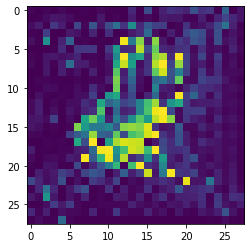

In [280]:
import matplotlib.pyplot as plt
plt.imshow(Bernoulli(logits=model(seed_image,max_steps,key=MODEL_KEY)[0][0]).mean())

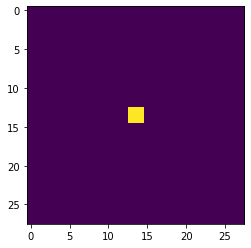

In [61]:
plt.imshow(Bernoulli(logits=seed_image[0]).mean())

In [62]:
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
    x0 = z_init
    x1 = f(x0)
    x2 = f(x1)
    X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
    F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])

    def step(n, k, X, F):
        G = F[:n] - X[:n]
        GTG = jnp.tensordot(G, G, [list(range(1, G.ndim))] * 2)
        H = jnp.block([[jnp.zeros((1, 1)), jnp.ones((1, n))],
                       [ jnp.ones((n, 1)), GTG]]) + lam * jnp.eye(n + 1)
        alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]

        xk = beta * jnp.dot(alpha, F[:n]) + (1-beta) * jnp.dot(alpha, X[:n])
        X = X.at[k % m].set(xk)
        F = F.at[k % m].set(f(xk))
        return X, F

    # unroll the first m steps
    for k in range(2, m):
        plt.imshow(X[k-1].reshape(latent_size,28,28)[0])
        plt.show()
        X, F = step(k, k, X, F)
        res = jnp.linalg.norm(F[k] - X[k]) / (1e-5 + jnp.linalg.norm(F[k]))
        if res < tol or k + 1 >= max_iter:
            return X[k], k

    # run the remaining steps in a lax.while_loop
    def body_fun(carry):
        k, X, F = carry
        X, F = step(m, k, X, F)
        return k + 1, X, F

    def cond_fun(carry):
        k, X, F = carry
        kmod = (k - 1) % m
        res = jnp.linalg.norm(F[kmod] - X[kmod]) / (1e-5 + jnp.linalg.norm(F[kmod]))
        return (k < max_iter) & (res >= tol)

    k, X, F = lax.while_loop(cond_fun, body_fun, (k + 1, X, F))
    return X[(k - 1) % m]

In [234]:
def forward_solver(flat_model,x):
    for i in range(70):
        x = flat_model(x)
        print(i)
        plt.imshow(sigmoid(x.reshape(latent_size,28,28)[0]))
        plt.show()

flat_model = lambda x : model.step(x.reshape(latent_size,28,28)).reshape(-1)    

flat_repeat_seed = repeat(seed_image[0],"h w -> (l h w)",l=latent_size)
#a = anderson_solver(flat_model, flat_repeat_seed,max_iter=100,m=30)

forward_solver(flat_model,flat_repeat_seed)

AttributeError: 'ModelStep' object has no attribute 'step'